In [1]:
import rasterio
import rasterio.plot 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# for aggegating raster values with shapefiles
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping

%matplotlib inline

# Definitions

In [2]:
def get_lon_lat_coordinates(filepath="../../data/features/pop.tif"):
    # Code comes from http://xarray.pydata.org/en/v0.10.0/auto_gallery/plot_rasterio.html
    import numpy as np
    import xarray as xr
    from rasterio.warp import transform
    
    # Read the data
    da = xr.open_rasterio(filepath)

    # Compute the lon/lat coordinates with rasterio.warp.transform
    ny, nx = len(da['y']), len(da['x'])
    x, y = np.meshgrid(da['x'], da['y'])

    # Rasterio works with 1D arrays
    lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
                         x.flatten(), y.flatten())

    lon = np.asarray(lon).reshape((ny, nx))
    lat = np.asarray(lat).reshape((ny, nx))
    
    # arrays with with shapes (849, 1469)
    return lon, lat
    #da.coords['lon'] = (('y', 'x'), lon)
    #da.coords['lat'] = (('y', 'x'), lat)

In [3]:
def get_featureData():
    featureData = pd.DataFrame()
    featureTifs = ["access", "pet", "pop", "urban", "W_access"]
    shape = (849, 1469)
    # Initiliase
    raster_na_value = None

    # get longitude and latitude
    lon, lat = get_lon_lat_coordinates("../../data/features/{}.tif".format(featureTifs[0]))
    lon_1d_array = lon.reshape(-1)
    lat_1d_array = lat.reshape(-1)
    featureData["longitude"] = lon_1d_array
    featureData["latitude"] = lat_1d_array

    for feature in featureTifs:
        filepath = "../../data/features/{}.tif".format(feature)
        # read raster data band1 from the .tif file
        rasterOpen = rasterio.open(filepath)
        rasterData = rasterOpen.read(1)
        rasterData_1d_array = rasterData.reshape(-1)
        featureData[feature] = rasterData_1d_array

        # raster data defines -3.4e+38 as the value, when data is missing
        raster_na_value = np.float32(rasterOpen.nodatavals[0])
        rasterOpen.close()
    
    return featureData, raster_na_value, shape

In [4]:
def get_predictions(data, modelPath):
    import tensorflow as tf
    model = tf.keras.models.load_model(modelPath)
    
    # Normalize data as 
    data = cleanedFeatureData.copy()
    data["longitude"] = data["longitude"] / 180
    data["latitude"] = data["latitude"] / 90
    
    predictions = model.predict(data.values, batch_size=32)
    return predictions

In [5]:
def prepare_predictions(predictions):
    # make predictions always 1d array
    predictions = predictions.reshape(-1)
    # set negative predicted values to zero, because values should not be < 0
    predictions[predictions < 0] = 0
    return predictions

In [6]:
def reshape_to_raster(array1D, raster_shape):
    return array1D.reshape(raster_shape)

In [7]:
def get_raster_data(featureData, cleanedFeatureData, modelPath, raster_na_value, raster_shape):
    # predictions takes longer, because there are about 0.5M Datapoints
    adj_cases_log_predictions = get_predictions(cleanedFeatureData, modelPath)
    
    labels = pd.DataFrame(index=cleanedFeatureData.index)
    labels["adj_cases_log"] = prepare_predictions(adj_cases_log_predictions)
    # adj_cases_log is log(adj_cases + 1)
    # Therefore adj_cases backwards is (exp(adj_cases_log) - 1)
    labels["adj_cases"] = np.exp(labels["adj_cases_log"]) - 1
    
    # fill not assigned label rows with raster_na_value
    # So are all NA values from prior raster_data masked
    labels = labels.reindex(featureData.index, fill_value=raster_na_value)
    
    return {"adj_cases_log": reshape_to_raster(labels["adj_cases_log"].values, raster_shape), 
            "adj_cases": reshape_to_raster(labels["adj_cases"].values, raster_shape)}


In [8]:
def save_raster(raster_data=None, file_name=None):
    filepath = "../../data/features/{}.tif".format("access")
    # read raster data band1 from the .tif file

    adj_cases_raster_opened = rasterio.open(filepath)
    adj_cases_raster = rasterio.open(
     "../../data/predictions/{}.tif".format(file_name),
     'w',
     driver='GTiff',
     height=raster_data.shape[0],
     width=raster_data.shape[1],
     count=1,
     dtype=raster_data.dtype,
     crs=adj_cases_raster_opened.crs,
     transform=adj_cases_raster_opened.transform,
     nodata=adj_cases_raster_opened.nodata
    )

    adj_cases_raster.write(raster_data, 1)
    adj_cases_raster.close()

In [9]:
def plot_rasters(raster_array, title):
    raster_array = raster_array.copy()
    raster_array[raster_array == raster_na_value] = np.nan
    plt.figure(figsize = (20,20))
    plt.title(title, fontdict={"fontsize": 50})
    plt.imshow(raster_array, cmap="hot")
    plt.tight_layout()

In [10]:
def save_raster_aggregated_shapefile(raster_name):
    shapefile = gpd.read_file("../../data/shapefiles/China.shp")
    # add adj_cases column with empty values to shapefile DataFrame
    shapefile.insert(loc=0, column="adj_cases", value=np.nan)

    # extract the raster values within the polygon 
    with rasterio.open("../../data/predictions/{}.tif".format(raster_name)) as src:
        for index, shape in enumerate(shapefile["geometry"]):
            # transform to GeJSON format
            geoms = [mapping(shape)]
            out_image, out_transform = mask(src, geoms, crop=True)
            # change nodata values to nan
            out_image[out_image == np.float32(src.nodata)] = np.nan
            shapefile.loc[index, "adj_cases"] = np.nansum(out_image)

    # Save modified Shapefile
    shapefile.to_file("../../data/predictions/shapefiles/{}.shp".format(raster_name), driver='ESRI Shapefile')

In [11]:
CONFIGS = {
    "one_hidden_layer": {
        "model_path": "../../best-models/one-hidden-layer",
        "raster_file_name": {
            "adj_cases_log": "adj_cases_log_h1",
            "adj_cases": "adj_cases_h1"
        }
    },
    "two_hidden_layers": {
        "model_path": "../../best-models/two-hidden-layers",
        "raster_file_name": {
            "adj_cases_log": "adj_cases_log_h2",
            "adj_cases": "adj_cases_h2"
        }
    }
}

# Generate Raster Maps and Shapefiles

In [12]:
CURRENT_CONFIG = CONFIGS["two_hidden_layers"]

In [13]:
featureData, raster_na_value, shape = get_featureData()
#featureData.to_csv("../../data/features/features.csv", index=True, index_label="index", na_rep="NA")

In [14]:
cleanedFeatureData = featureData.replace(raster_na_value,np.NaN).dropna()
#cleanedFeatureData.to_csv("../../data/features/cleaned-features.csv", index=True, index_label="index", na_rep="NA")

In [15]:
# Takes longer to predict 0.5M Datapoints
raster_data = get_raster_data(featureData, 
                              cleanedFeatureData, 
                              CURRENT_CONFIG["model_path"], 
                              raster_na_value,
                              shape)

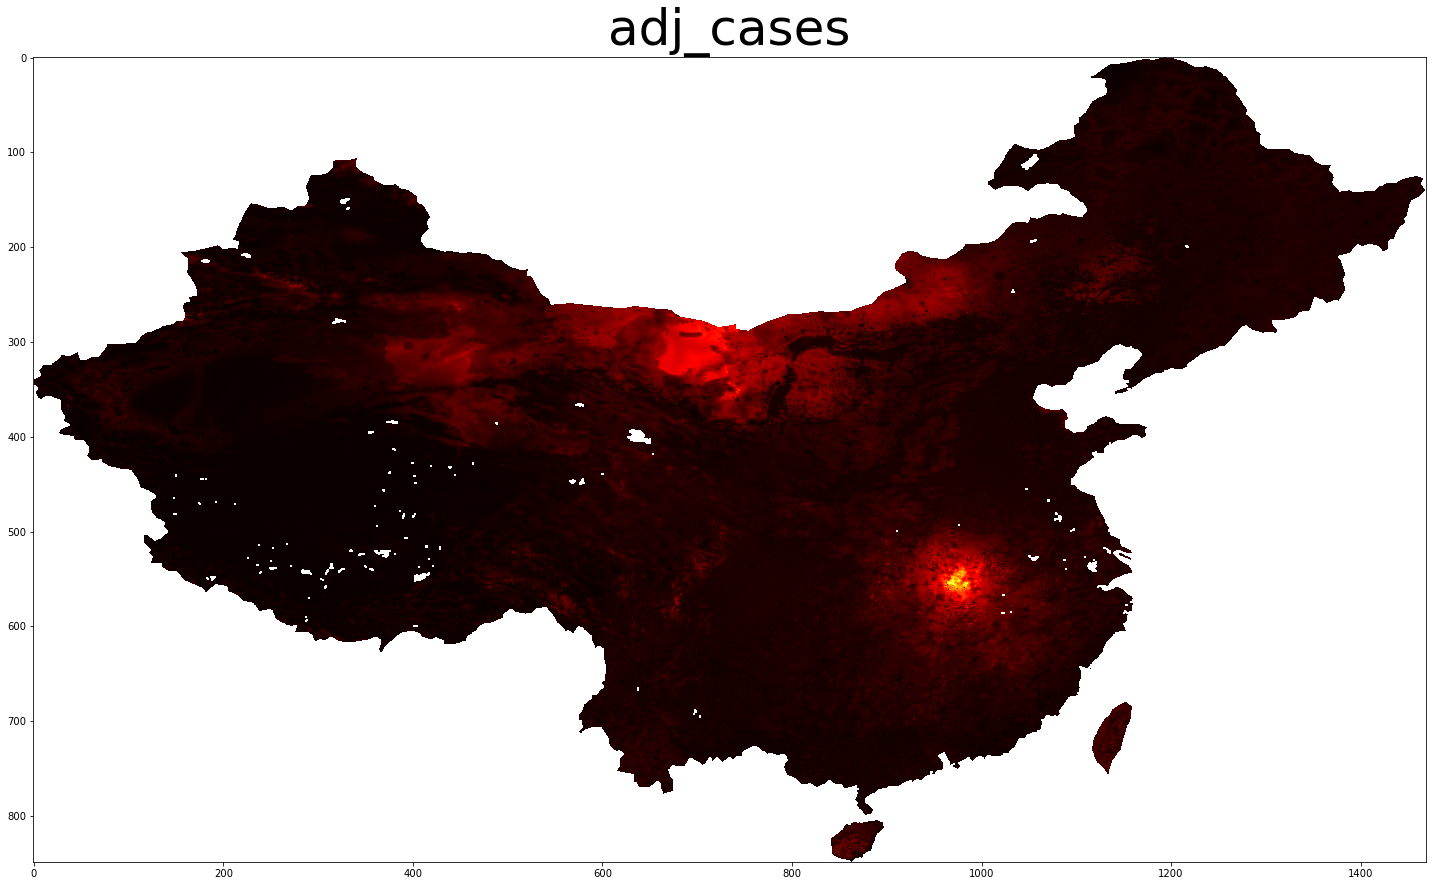

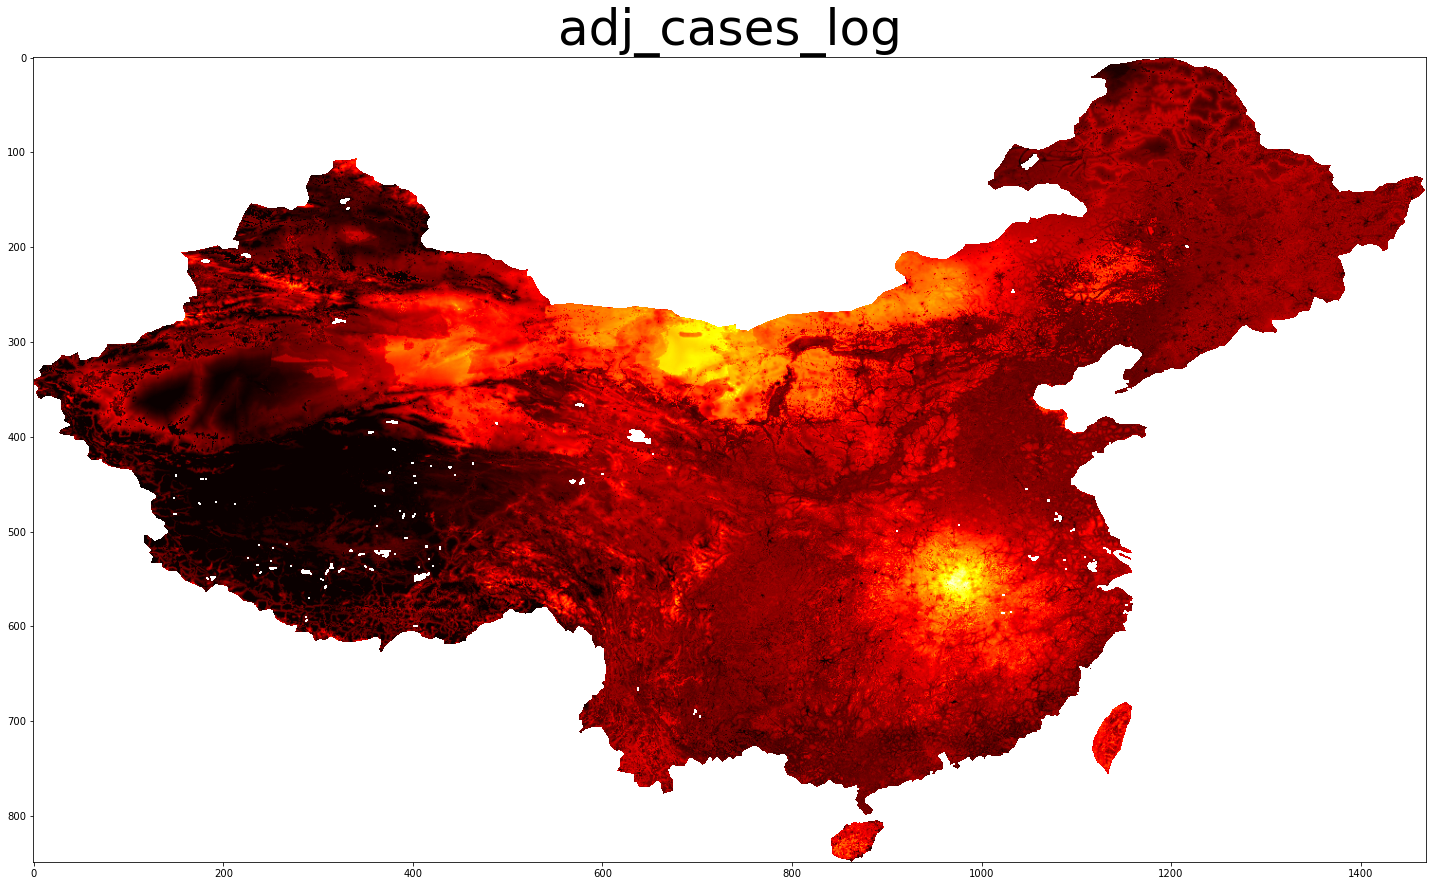

In [16]:
for label_name in ["adj_cases", "adj_cases_log"]:
    # Save raster file for the label
    save_raster(raster_data=raster_data[label_name], 
                file_name=CURRENT_CONFIG["raster_file_name"][label_name])
    # Aggregate raster values by China's shapefile and save new shapefile
    save_raster_aggregated_shapefile(raster_name=CURRENT_CONFIG["raster_file_name"][label_name])
    # Plot Rasters
    plot_rasters(raster_data[label_name], label_name)